# Tensorflow DNN_experiment
## 這章節主要讓大家針對activation function,loss function, learning rate, and optimizer做選擇的練習
### 前面部分與overview都一樣，故拿掉我們更動前的所有大標，避免版面混亂
### 修改位置：graph

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os
os.chdir('//data/examples/')

In [ ]:
#我們已經將所有的圖片的相對路徑以及label存成csv檔，所以在這邊我們先去呼叫這份檔案
simpson_img = pd.read_csv('simpson_preproc/simpson_img_list.csv')
print(simpson_img.head())

In [ ]:
img = cv2.imread('simpson_preproc/' + simpson_img.img.iloc[0], 0)


In [0]:
simpson_img = simpson_img[simpson_img.img.str.contains('simpson')]#只取名字含有'simpson'的

In [0]:
simpson_y = pd.get_dummies(simpson_img['classname'], '').as_matrix()#將label做 one_hot encoding
print(simpson_y)

[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 ..., 
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


In [0]:
x_train_list, y_train = simpson_img, simpson_y #資料切割
## record the dim of img ##
img = cv2.resize(img, (50,50))#改變圖片大小(太大會跑太久)
img = img.flatten()


input_data shape: training (7274, 2500)
y_true shape: training (7274, 6)


In [0]:
from sklearn.utils import shuffle 

def simpson_train_batch_generator(x, y, bs, shape):
    x_train = np.array([]).reshape((0, shape))
    y_train = np.array([]).reshape((0, y.shape[1]))
    while True:
        new_ind = shuffle(range(len(x)))
        x = x.take(new_ind)
        y = np.take(y, new_ind, axis=0)
        for i in range(len(x)):
            dir_img = 'simpson_preproc/' + x.img.iloc[i]
            img = cv2.imread(dir_img, 0)
            img = cv2.resize(img, (50,50))
            x_train = np.row_stack([x_train, img.flatten()])
            y_train = np.row_stack([y_train, y[i]])
            if x_train.shape[0] == bs:
                x_batch = x_train.copy()
                x_batch /= 255.
                y_batch = y_train.copy()
                x_train = np.array([]).reshape((0 ,shape))
                y_train = np.array([]).reshape((0 ,y.shape[1]))        
                yield x_batch, y_batch

# create graph

## $\star\star$章節重點 activation function,loss function, learning rate, and optimizer$\star\star$

In [0]:
tf.reset_default_graph() ## 將graph reset,重新 build graph 需要跑這行

In [0]:
#### define placeholder ####
input_data = tf.placeholder(dtype=tf.float32, 
                           shape=[None, img.shape[0]],
                           name='input_data') #用來接 feature 資料進入 tensorflow 

y_true = tf.placeholder(dtype=tf.float32, 
                        shape=[None, y_train.shape[1]],
                        name='y_true') #用來接 label 資料進入 tensorflow 

### 1. activation function
常被使用的有sigmoid, tanh, relu, selu, softmax。 在tensorflow其他還有 leaky_relu, elu, relu6, crelu, softplus, softsign, etc...
https://www.tensorflow.org/api_guides/python/nn

tips1:將dense中的activation設成None，就是linear的activation(多用於regression時的output layer)。https://www.tensorflow.org/api_docs/python/tf/layers/dense

tips2:output layer的activation function多會跟loss function寫成同一個function，所以不會在這設定

In [0]:
#### define variables(weight/bias) ####
x1 = tf.layers.dense(input_data, 256, activation=tf.nn.sigmoid, name='hidden1') #第一層hidden layer
x2 = tf.layers.dense(x1, 128, activation=tf.nn.sigmoid, name='hidden2') #第二層hidden layer
x3 = tf.layers.dense(x2, 64, activation=tf.nn.sigmoid, name='hidden3')#第三層hidden layer
out = tf.layers.dense(x3, y_train.shape[1], name='output')# output layer

y_pred = out

### 2. loss function
分類問題多用cross entropy, regression問題則多用MSE，視問題的不同而選擇

In [0]:
#### calculate loss ####
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

### 3. optimizer
最基本是GradientDescentOptimizer, 常被使用的還有AdagradOptimizer, AdamOptimizer, MomentumOptimizer。 tensorflow中, 其他optimizer還有 AdagradDAOptimizer, ProximalAdagradOptimizer, RMSPropOptimizer, etc...
### 4. learning rate
視情況進行調整

In [0]:
#### optimize variables ####
opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)

update = opt.minimize(loss)

In [0]:
tf.global_variables() ## 檢查 graph 裏的 global variables

[<tf.Variable 'hidden1/kernel:0' shape=(2500, 256) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'hidden2/kernel:0' shape=(256, 128) dtype=float32_ref>,
 <tf.Variable 'hidden2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'hidden3/kernel:0' shape=(128, 64) dtype=float32_ref>,
 <tf.Variable 'hidden3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'output/kernel:0' shape=(64, 6) dtype=float32_ref>,
 <tf.Variable 'output/bias:0' shape=(6,) dtype=float32_ref>]

# run session


## step 1: run global variables initialization

In [0]:
#### init ####
init = tf.global_variables_initializer()

In [0]:
sess = tf.Session()
sess.run(init)

## step 2: run session to update the variables

In [0]:
from tqdm import tqdm_notebook #用來顯示進度條的套件
from sklearn.metrics import accuracy_score

epoch = 30 #要跑多少epoch
bs = 32 #設定看過幾筆資料走一次更新(batch size)
update_per_epoch = 100 #一個epoch要跑幾個batch
'''因為我們現在是用generator產生新的batch，所以我們要自行給定一個epoch要跑幾個batch,
當然也可以另外修改程式讓generator回傳適合的batch數(total number of data/batch size)'''

tr_loss = list() #準備一個空的list用來存training過程中的loss值
tr_acc = list() #準備一個空的list用來存training過程中的準確率
train_gen = simpson_train_batch_generator(x_train_list, y_train, bs, img.shape[0])

print('start modelling!')

for i in range(epoch):
    
    #### calculate training loss & update variables ####
    training_loss = 0 #用來計算epoch內所有batch loss的平均值，所以在每個epoch一開始要歸零
    training_acc = 0#用來計算epoch內所有batch acc的平均值，所以在每個epoch一開始要歸零
    bar = tqdm_notebook(range(update_per_epoch)) #外面的tqdm是進度條的function
    
    for j in bar:
        
        x_batch, y_batch = next(train_gen) #我們是用yield來寫generator,所以用next取得下一筆資料
        
        tr_pred, training_loss_batch, _ = sess.run([y_pred, loss, update], feed_dict={
            input_data:x_batch,
            y_true:y_batch
        })
        
        training_loss += training_loss_batch
        
        training_acc_batch = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(tr_pred, axis=1))
        training_acc += training_acc_batch
        
        if j % 5 == 0:
            bar.set_description('loss: %.4g' % training_loss_batch) 
            #每5次batch更新顯示的batch loss(進度條前面)

    training_loss /= update_per_epoch
    training_acc /= update_per_epoch
    
    tr_loss.append(training_loss)
    tr_acc.append(training_acc)
    
    print('epoch {epochs}: training loss {training_loss}'.format(
            epochs=(i+1), 
            training_loss=training_loss))#每個epoch結束後顯示目前的的training loss


start modelling!


HBox(children=(IntProgress(value=0), HTML(value='')))

Exception in thread Thread-41:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




epoch 1: training loss 1.6706854212284088


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 2: training loss 1.660754224061966


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 3: training loss 1.6540946984291076


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 4: training loss 1.6396492385864259


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 5: training loss 1.6378844153881074


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 6: training loss 1.6361370861530304


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 7: training loss 1.645018880367279


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 8: training loss 1.6333312320709228


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 9: training loss 1.6340489768981934


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 10: training loss 1.638424836397171


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 11: training loss 1.6263027966022492


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 12: training loss 1.6261225593090058


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 13: training loss 1.636438913345337


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 14: training loss 1.6328670811653136


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 15: training loss 1.6206371915340423


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 16: training loss 1.6339889144897461


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 17: training loss 1.6252104341983795


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 18: training loss 1.6256825423240662


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 19: training loss 1.635836454629898


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 20: training loss 1.6234931635856629


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 21: training loss 1.6275943386554719


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 22: training loss 1.6311800730228425


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 23: training loss 1.6177259516716003


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 24: training loss 1.6338687121868134


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 25: training loss 1.623934907913208


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 26: training loss 1.6244584977626801


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 27: training loss 1.626653938293457


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 28: training loss 1.6246866059303284


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 29: training loss 1.6275024759769439


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 30: training loss 1.6268797242641448


Text(0.5,1,'Accuracy')

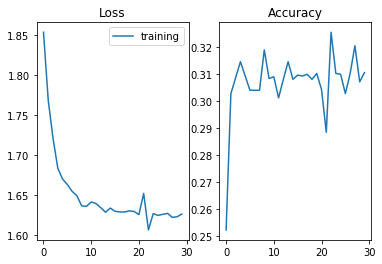

In [0]:
plt.figure(1)
plt.subplot(121)
plt.plot(range(len(tr_loss)), tr_loss, label='training')
plt.title('Loss')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(range(len(tr_acc)), tr_acc, label='training')
plt.title('Accuracy')

In [0]:
print(sess.run(loss, feed_dict={
            input_data:x_batch,
            y_true:y_batch
        }))

1.6104


## 試問:結果有變好嗎?不好?繼續換吧!